### online_shoppers_intention 
- 가입고객 이탈 예측 
1. 데이터 전처리 결과서
2. 인공지능 학습 결과서
3. 학습된 인공지능 모델
4. streamlit 앱(github)

# 프로젝트 개요
- 주제: 온라인 쇼핑몰 방문자 행동 데이터 기반 구매 전환 예측 및 이탈 방지 전략 수립
- 목표: `방문자 행동 데이터를 기반으로 구매 전환 여부 예측`, `이탈 가능성이 높은 사용자 패턴을 분석해 이탈 방지 & 매출 상승 전략 수립`
- 분석 관점: `누가 구매하는가?`, `누가 이탈하는가?`, `어떤 행동이 전환을 만드는가?`

## 1. 데이터 설명 + 컬럼 설명 
데이터 개요
- 행(row): 세션 단위 방문 기록 
- 열(column): 페이지 탐색량, 체류시간, 이달/종료율, 유입채널, 방문자 유형 등
- 타겟변수: `Revenue` True(구매 발생), False(이탈_구매 전환 실패)
- 특징: 클릭/체류/페이지 이동 기반 행동데이터, 마케팅 유입 채널 정보 포함, 구매여부가 이진 분류로 되어 있음

### 컬럼 설명
| 컬럼명                       | 설명              | 활용 목적    |
| ------------------------- | --------------- | -------- |
| `Administrative`          | 관리자/정책 페이지 방문 수 | 정보 탐색 깊이 |
| `Administrative_Duration` | 관리자 페이지 체류 시간   | 구매 의도 강도 |
| `Informational`           | 정보성 페이지 방문 수    | 비교/탐색 단계 |
| `Informational_Duration`  | 정보 페이지 체류 시간    | 의사결정 준비  |
| `ProductRelated`          | 상품 페이지 방문 수     | 핵심 구매 신호 |
| `ProductRelated_Duration` | 상품 페이지 체류 시간    | 구매 전환 핵심 |
| `BounceRates`             | 이탈률             | 즉시 이탈 판단 |
| `ExitRates`               | 종료 페이지 비율       | 이탈 시점 분석 |
| `PageValues`              | 페이지 가치 점수       | 전환 기여도   |
| `SpecialDay`              | 특정 기념일 근접도      | 프로모션 효과  |
| `Month`                   | 방문 월            | 시즌성 분석   |
| `OperatingSystems`        | OS 정보           | 기술 환경    |
| `Browser`                 | 브라우저            | UX 이슈    |
| `Region`                  | 지역              | 지역별 전환   |
| `TrafficType`             | 유입 경로           | 마케팅 성과   |
| `VisitorType`             | 신규/재방문          | 리텐션      |
| `Weekend`                 | 주말 여부           | 구매 타이밍   |
| `Revenue`                 | 구매 여부 (Target)  | 예측 대상    |

구매는 행동의 누적 결과 이기 때문에 체류 + 페이지 + 이탈 지표를 중심으로 분석


### 전처리 전략
| 작업       | 이유         |
| -------- | ---------- |
| 결측치 확인   | 모델 안정성     |
| 범주형 인코딩  | ML 입력값 변환  |
| 이상치 확인   | 왜곡 방지      |
| 타겟 분포 확인 | 클래스 불균형 확인 |

In [1]:
# 데이터로드 & 기본 확인

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# 데이터 로드 및 확인
df = pd.read_csv('data/online_shoppers_intention.csv')
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [3]:
# 결측치 없음 확인
df.isnull().sum()

# 결측치는 거의 없음 

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [4]:
# 범주형 변수 타입 변환
categorical_cols = ['Month', 'VisitorType', 'Weekend', 'Revenue']

for col in categorical_cols:
    df[col] = df[col].astype('category')

In [5]:
# 타겟 분포 확인
df['Revenue'].value_counts(normalize=True)

Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64

In [6]:
# 타겟 변수 변환 
df['Revenue'] = df['Revenue'].astype(int)

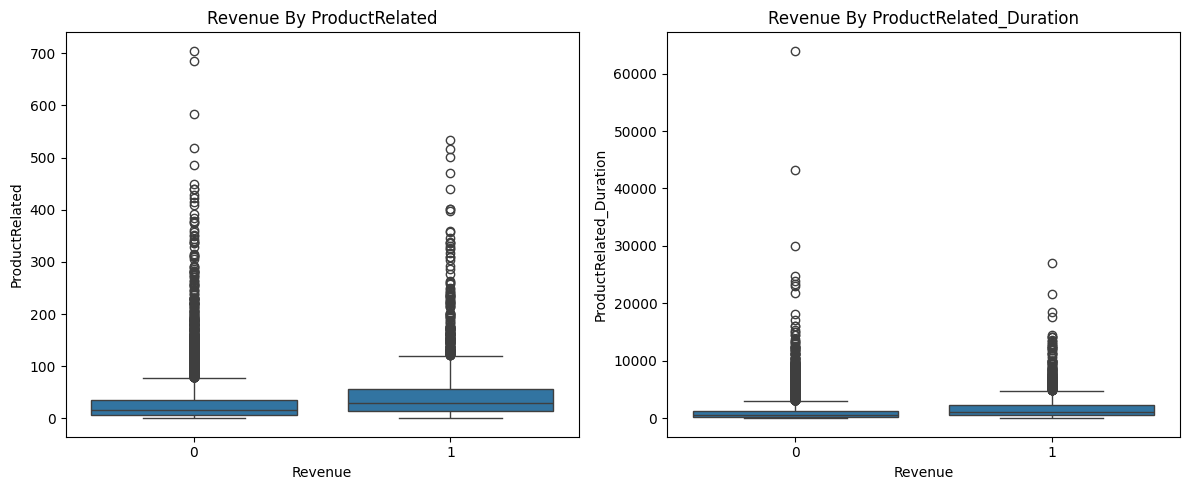

In [7]:
# 구매 여부에 따른 페이지 방문 행동 비교
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x='Revenue', y='ProductRelated', data=df)
plt.title("Revenue By ProductRelated") # 구매 여부별 상품 페이지 방문 수

plt.subplot(1,2,2)
sns.boxplot(x='Revenue', y='ProductRelated_Duration', data=df)
plt.title("Revenue By ProductRelated_Duration") # 구매 여부별 상품 페이지 체류 시간

plt.tight_layout()
plt.show()


## 구매한 사용자는 상품 페이지 방문수와 체류 시간이 명확히 높음
- 구매 전환은 '페이지수'보다 체류시간의 영향이 큰것으로 확인됨 
- 상품 상세 페이지 UX 개선이 전환율에 영향을 미침

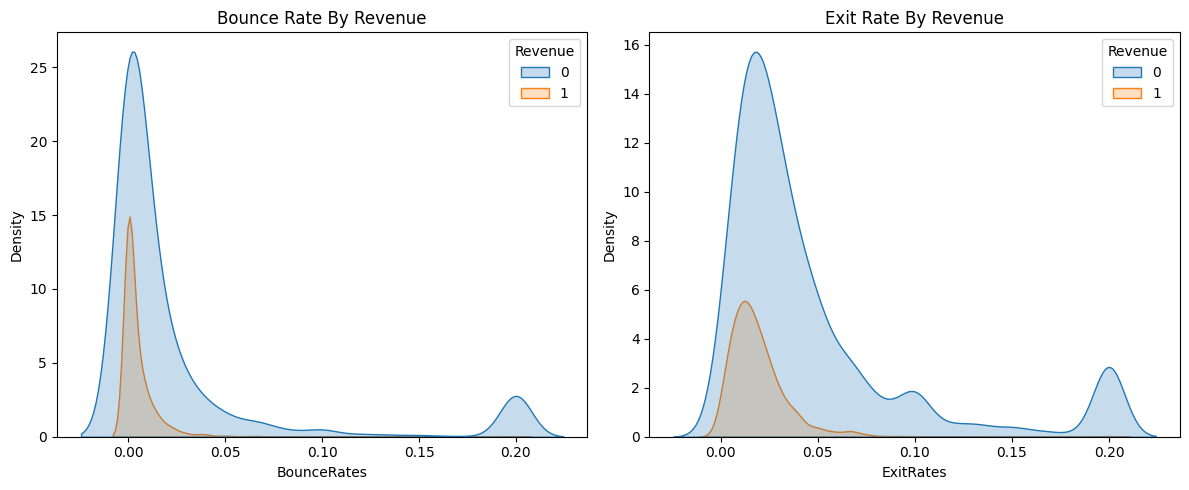

In [8]:
# 이탈 행동(Bounce/Exit)과 구매 관계
# KDE Plot을 활용한 이탈률, 종료율 확인 
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.kdeplot(data=df, x='BounceRates', hue='Revenue', fill=True)
plt.title("Bounce Rate By Revenue") # 구매 여부별 Bounce Rate 분포

plt.subplot(1,2,2)
sns.kdeplot(data=df, x='ExitRates', hue='Revenue', fill=True)
plt.title("Exit Rate By Revenue") # 구매 여부별 Exit Rate 분포

plt.tight_layout()
plt.show()

## 구매 하지 않은 그룹은 높은 이탈률과 종료율 구간에 집중 되어 있음
- 이탈률이 높다면, 랜딩페이지의 콘텐츠, 디자인 개선을 통해 구객이 한페이지만 보고 떠나지 않도록 초기 방문의 매력도를 높여야 한다 
- 종료율이 높다면, 구매 전환율이 높은 페이지를 확인하여, 결제 프로세스의 풀편함이나 불필요한 이탈 요소를 제거해야한다. 


C:\Users\Playdata\AppData\Local\Temp\ipykernel_11548\2628067151.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_rate = df.groupby('VisitorType')['Revenue'].mean().reset_index()


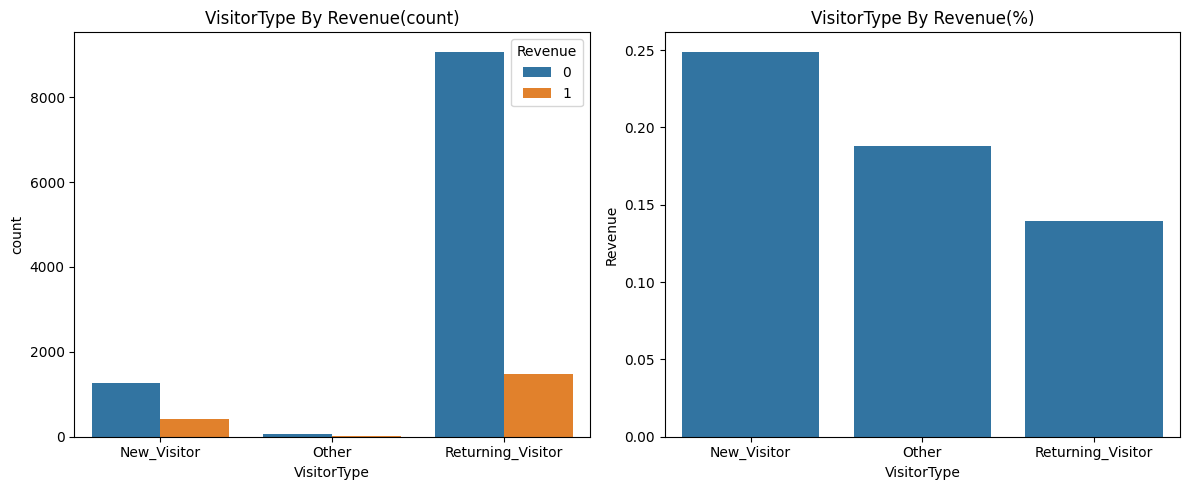

In [9]:
# 방문자 유형에 따른 구매 전환
# Countplot: VisitorType vs Revenue
# Barplot: 구매율 비교
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x='VisitorType', hue='Revenue', data=df)
plt.title("VisitorType By Revenue(count)") # 방문자 유형별 구매 여부 분포

plt.subplot(1,2,2)
purchase_rate = df.groupby('VisitorType')['Revenue'].mean().reset_index()
sns.barplot(x='VisitorType', y='Revenue', data=purchase_rate)
plt.title("VisitorType By Revenue(%)") # 방문자 유형별 구매 전환율

plt.tight_layout()
plt.show()


## 방문자의 대부분이 구매를 하지 않는 것으로 보임  
- 신규 방문자의 전환율이 재방문자 대비 약 10% 높은 수준 보임 
- 신규 유입 -> 재방문 유도 전략 필수

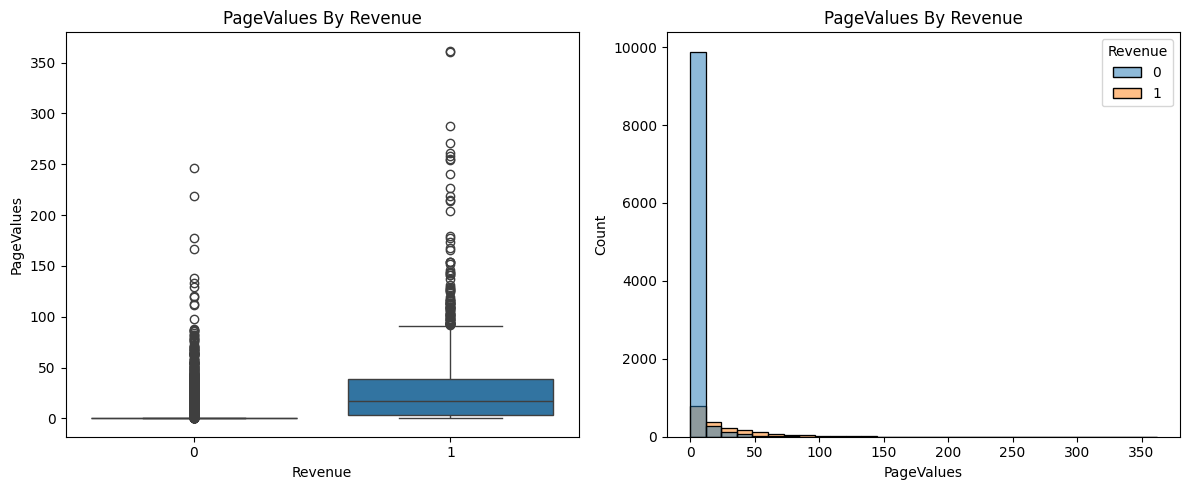

In [10]:
# PageValue와 구매의 관계 (강력)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x='Revenue', y='PageValues', data=df)
plt.title("PageValues By Revenue") # 구매 여부별 Page Value 분포

plt.subplot(1,2,2)
sns.histplot(data=df, x='PageValues', hue='Revenue', bins=30)
plt.title("PageValues By Revenue") # Page Value 분포 비교

plt.tight_layout()
plt.show()


## box plot PageValues 가 보다 훨씬 높은 위치에서 구매건이 높게 나타나고, hitstplot에서는 구매를 하지 않은 그룹 대부분이 PageValues가 0에 가까움
- PageValue는 구매 전환에 가장 강력한 단일 지표로 보여짐


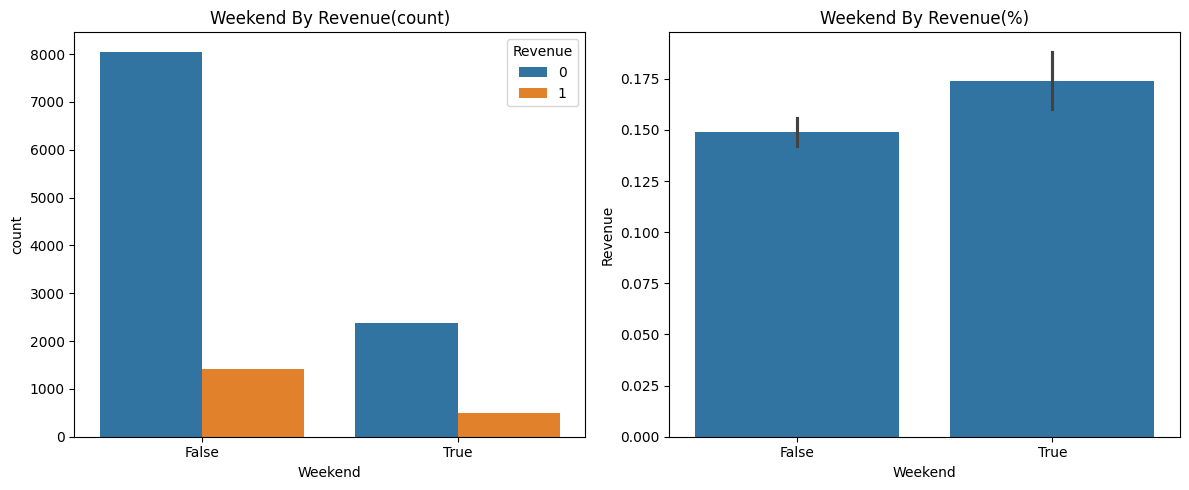

In [11]:
## 주말 vs 평일 구매 패턴

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x='Weekend', hue='Revenue', data=df)
plt.title("Weekend By Revenue(count)") # 주말 여부별 구매 분포

plt.subplot(1,2,2)
sns.barplot(x='Weekend', y='Revenue', data=df)
plt.title("Weekend By Revenue(%)") # 주말 여부별 구매 전환율

plt.tight_layout()
plt.show()

## 평일5일 / 주말2일의 영향으로 절대값의 차이를 보이고 있으며, 전환율 확인 결과 주말이 평일보다 높은 구매 전환율 보임 
- 주말 집중 프로모션 전략을 활용한 주말 구매수 증대 필요

C:\Users\Playdata\AppData\Local\Temp\ipykernel_11548\779963919.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_rate = df.groupby('VisitorType')['BounceRates'].mean().reset_index()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_11548\779963919.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_rate = df.groupby('VisitorType')['ExitRates'].mean().reset_index()


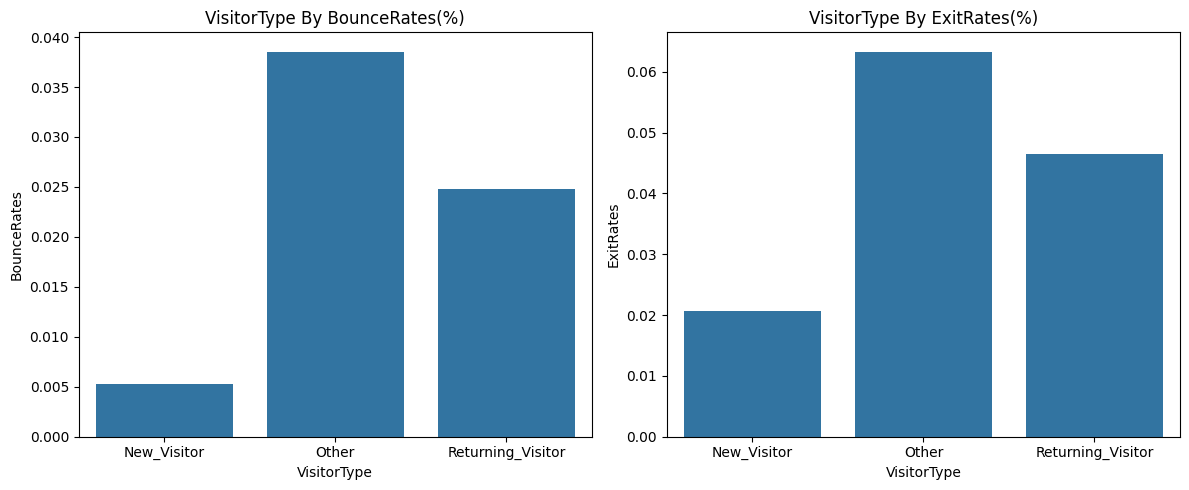

In [12]:
# 방문자 유형에 따른 구매 전환
# Countplot: VisitorType vs Revenue
# Barplot: 구매율 비교
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
purchase_rate = df.groupby('VisitorType')['BounceRates'].mean().reset_index()
sns.barplot(x='VisitorType', y='BounceRates', data=purchase_rate)
plt.title("VisitorType By BounceRates(%)") # 방문자 유형별 구매 여부 분포

plt.subplot(1,2,2)
purchase_rate = df.groupby('VisitorType')['ExitRates'].mean().reset_index()
sns.barplot(x='VisitorType', y='ExitRates', data=purchase_rate)
plt.title("VisitorType By ExitRates(%)") # 방문자 유형별 구매 전환율

plt.tight_layout()
plt.show()


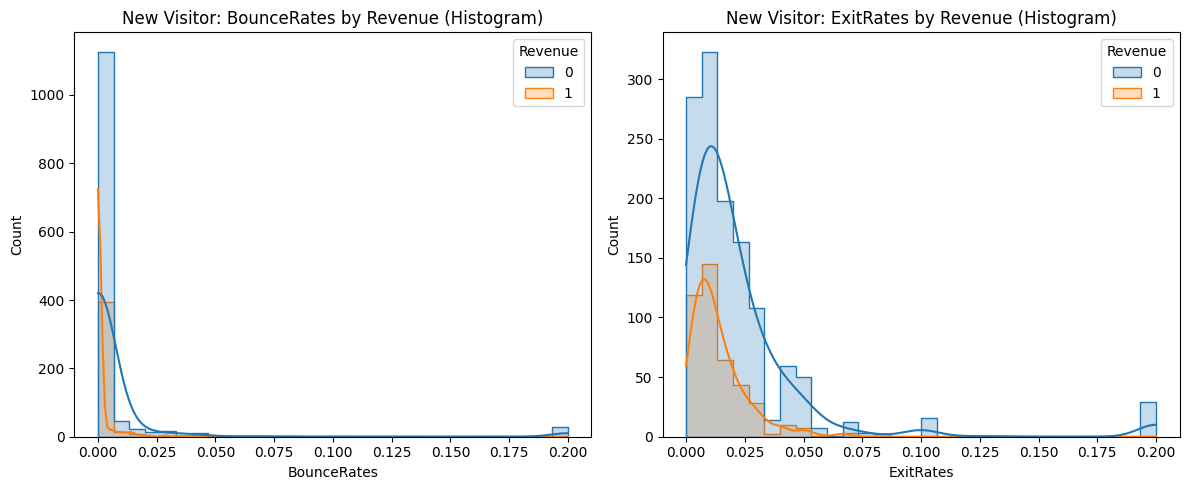

In [14]:
df[df['VisitorType'] == 'New_Visitor']

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
93,0,0.000,0,0.0,13,649.250000,0.000000,0.015385,0.000000,0.0,Feb,2,2,1,5,New_Visitor,False,0
196,2,56.000,1,144.0,67,2563.783333,0.000000,0.005797,19.342650,0.0,Mar,2,2,4,2,New_Visitor,False,1
198,0,0.000,0,0.0,17,840.233333,0.000000,0.001667,109.176000,0.0,Mar,2,2,9,2,New_Visitor,False,1
199,3,94.000,2,125.0,55,1970.844805,0.000000,0.001724,96.255116,0.0,Mar,2,4,1,2,New_Visitor,True,1
202,5,218.000,0,0.0,13,284.500000,0.000000,0.004167,0.000000,0.0,Mar,1,1,1,2,New_Visitor,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12276,7,139.575,0,0.0,30,986.500000,0.000000,0.011429,36.392861,0.0,Dec,2,10,1,2,New_Visitor,False,1
12296,0,0.000,0,0.0,5,108.000000,0.000000,0.040000,0.000000,0.0,Dec,2,2,1,2,New_Visitor,False,0
12297,0,0.000,0,0.0,6,139.750000,0.033333,0.066667,0.000000,0.0,Nov,2,2,3,2,New_Visitor,False,0
12317,3,100.500,0,0.0,95,1453.640882,0.002105,0.012761,0.000000,0.0,Dec,2,2,3,2,New_Visitor,False,0
